In [1]:
!pip install transformers --quiet
import json
import math
import random
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config, get_linear_schedule_with_warmup, pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
myDrive_path = '/content/gdrive/My Drive/'
dir_path = os.path.join(myDrive_path, 'Intent_Analysis_Final_Project', 'intent-analysis-gpt2')

Mounted at /content/gdrive


In [3]:
data_name = "en-US.jsonl"
data_path = os.path.join(dir_path, data_name)
data = []
with open(data_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
unique_intents = sorted(list(set([entry['intent'] for entry in data])))
print(unique_intents)
print(f"Number of unique intents: {len(unique_intents)}")

['alarm_query', 'alarm_remove', 'alarm_set', 'audio_volume_down', 'audio_volume_mute', 'audio_volume_other', 'audio_volume_up', 'calendar_query', 'calendar_remove', 'calendar_set', 'cooking_query', 'cooking_recipe', 'datetime_convert', 'datetime_query', 'email_addcontact', 'email_query', 'email_querycontact', 'email_sendemail', 'general_greet', 'general_joke', 'general_quirky', 'iot_cleaning', 'iot_coffee', 'iot_hue_lightchange', 'iot_hue_lightdim', 'iot_hue_lightoff', 'iot_hue_lighton', 'iot_hue_lightup', 'iot_wemo_off', 'iot_wemo_on', 'lists_createoradd', 'lists_query', 'lists_remove', 'music_dislikeness', 'music_likeness', 'music_query', 'music_settings', 'news_query', 'play_audiobook', 'play_game', 'play_music', 'play_podcasts', 'play_radio', 'qa_currency', 'qa_definition', 'qa_factoid', 'qa_maths', 'qa_stock', 'recommendation_events', 'recommendation_locations', 'recommendation_movies', 'social_post', 'social_query', 'takeaway_order', 'takeaway_query', 'transport_query', 'transpor

In [5]:
class IntentDataset(Dataset):
    def __init__(self, data, unique_intents, tokenizer, partition='dev'):
        self.data = data
        self.current_dataset = [entry for entry in self.data if entry['partition'] == partition]
        self.intents = [entry["intent"] for entry in self.current_dataset]
        self.unique_intents = unique_intents
        self.tokenizer = tokenizer
        self.intent_to_id = {intent: i for i, intent in enumerate(self.unique_intents)}
        self.id_to_intent = {i: intent for intent, i in self.intent_to_id.items()}
        self.labels = [self.intent_to_id[intent] for intent in self.intents]
        self.input_data = []
        for entry in self.current_dataset:
            scenario, utt = entry['scenario'], entry['utt']

            # remove stop words
            stop_words = set(stopwords.words('english'))
            utt = [word for word in utt.split() if word.lower() not in stop_words]

            # stemming
            stemmer = PorterStemmer()
            utt = " ".join([stemmer.stem(word) for word in utt])

            self.input_data.append(scenario + " <|> " + utt)
        self.encodings = self.tokenizer(self.input_data, return_tensors='pt', padding=True, truncation=True)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [6]:
class GPT2ForSequenceClassification(nn.Module):
    def __init__(self, config, num_labels):
        super().__init__()
        self.gpt2 = GPT2Model(config)
        self.dropout = nn.Dropout(0.6)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.gpt2(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss, logits
        else:
            return logits

In [7]:
batch_size = 10
model_engine = "gpt2-medium"

tokenizer = GPT2Tokenizer.from_pretrained(model_engine)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

trainset = IntentDataset(data, unique_intents, tokenizer, partition='train')
valset = IntentDataset(data, unique_intents, tokenizer)
trainLoader = DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
valLoader = DataLoader(valset, batch_size, shuffle=False, num_workers=2)

In [8]:
index = 1
data_item = trainset[index]

# Extract input_ids, attention_mask, and label from the data_item
input_ids = data_item['input_ids']
attention_mask = data_item['attention_mask']
label = data_item['label']

# Print the original text and label by decoding the input_ids
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
print(f"Text: {decoded_text}")
print(f"Label: {label.item()}")
print(f"True Label: {trainset.id_to_intent[label.item()]}")

Text: alarm <|> set alarm two hour
Label: 2
True Label: alarm_set


In [9]:
# {"id": "2", "locale": "en-US", "partition": "train", "scenario": "alarm", "intent": "alarm_set", "utt": "set an alarm for two hours from now", "annot_utt": "set an alarm for [time : two hours from now]", "worker_id": "1"}

In [11]:
num_labels = len(unique_intents)
config = GPT2Config.from_pretrained(model_engine)
model = GPT2ForSequenceClassification(config, num_labels)
model.gpt2.resize_token_embeddings(len(tokenizer))

# model_name = "gpt2-intent-analysis-65acc"
# model_path = os.path.join(dir_path, model_name)
# if os.path.exists(model_path):
#     model.load_state_dict(torch.load(model_path))
#     print(f"Loaded model: {model_name}")
# else:
#     print(f"Ready to train model: {model_name}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [12]:
def find_lr(model, dataloader, optimizer, init_lr=1e-8, final_lr=10, beta=0.98):
    num_batches = len(dataloader)
    mult = (final_lr / init_lr) ** (1 / num_batches)
    lr = init_lr
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0
    best_loss = 0
    batch_num = 0
    losses = []
    log_lrs = []
    for batch in dataloader:
        batch_num += 1
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** batch_num)
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        loss.backward()
        optimizer.step()
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

def plot_lr_finder(log_lrs, losses):
    plt.plot(log_lrs, losses)
    plt.xlabel('Learning rate (log10 scale)')
    plt.ylabel('Loss')
    plt.savefig('lr.pdf', format='pdf', bbox_inches='tight')
    plt.show()


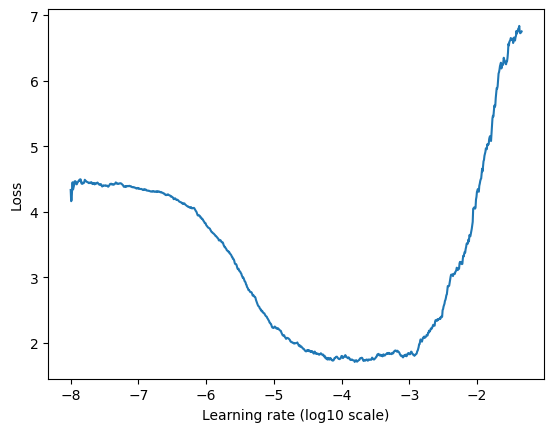

In [14]:
# Freeze 10 layers
num_layers = 10
for param in model.gpt2.h[:num_layers].parameters():
    param.requires_grad = False
for param in model.gpt2.h[num_layers:].parameters():
    param.requires_grad = True

# Pre-train on lr
init_lr = 1e-8
init_optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=0.01)
log_lrs, losses = find_lr(model, trainLoader, init_optimizer, final_lr=1)
plot_lr_finder(log_lrs, losses)

In [15]:
min_loss_idx = np.argmin(losses)
optimal_log_lr = log_lrs[min_loss_idx]
optimal_lr = 10 ** optimal_log_lr
print(optimal_lr)

0.00015647481416579328


In [ ]:
epochs = 6

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=optimal_lr, weight_decay=0.01)

# Scheduler
total_steps = len(trainLoader) * epochs
warmup_ratio = 0.05
warmup_steps = int(warmup_ratio * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

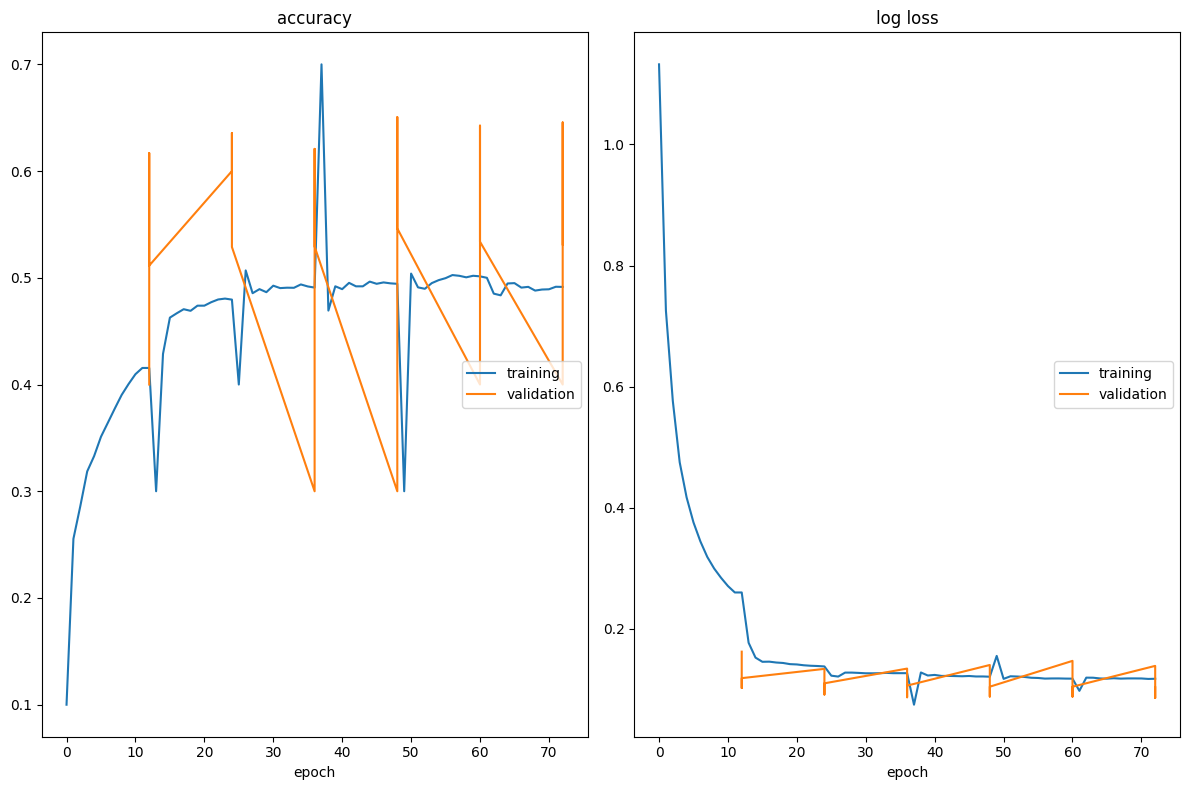

accuracy
	training         	 (min:    0.100, max:    0.700, cur:    0.491)
	validation       	 (min:    0.300, max:    0.650, cur:    0.531)
log loss
	training         	 (min:    0.075, max:    1.132, cur:    0.117)
	validation       	 (min:    0.086, max:    0.162, cur:    0.103)


In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

liveloss = PlotLosses()
current_step = 0
for epoch in range(epochs):
    logs = {}
    cumulative_loss = 0
    cumulative_accuracy = 0
    num_samples = 0

    model.train()
    # print("In training loop...")
    for id, batch in enumerate(trainLoader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        model.zero_grad()
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        scheduler.step()

        cumulative_loss += loss.item()
        preds = torch.argmax(outputs[1], dim=1)
        cumulative_accuracy += (preds == labels).sum().item()
        num_samples += labels.size(0)

        if id % 100 == 0:
            avg_train_loss = cumulative_loss / num_samples
            avg_train_accuracy = cumulative_accuracy / num_samples
            # print(f"Epoch {epoch}, Batch id: {id}, Accuracy: {avg_train_accuracy}, Loss: {avg_train_loss}")
            logs['log loss'] = avg_train_loss
            logs['accuracy'] = avg_train_accuracy
            liveloss.update(logs)
            liveloss.send()
            current_step += 1

    model.eval()
    cumulative_loss = 0
    cumulative_accuracy = 0
    num_samples = 0
    # print("In validation loop...")
    with torch.no_grad():
        for id, batch in enumerate(valLoader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            cumulative_loss += loss.item()
            preds = torch.argmax(outputs[1], dim=1)
            cumulative_accuracy += (preds == labels).sum().item()
            num_samples += labels.size(0)

            if id % 100 == 0:
                avg_val_loss = cumulative_loss / num_samples
                avg_val_accuracy = cumulative_accuracy / num_samples
                # print(f"Epoch {epoch}, Batch id: {id}, Accuracy: {avg_val_accuracy}, Loss: {avg_val_loss}")
                logs['val_log loss'] = avg_val_loss
                logs['val_accuracy'] = avg_val_accuracy
                liveloss.update(logs, current_step)
                liveloss.send()


In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
def predict_intent(inputs, model=model):
    model.eval()
    input_ids = inputs['input_ids'].unsqueeze(0).to(device)
    attention_mask = inputs['attention_mask'].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs, dim=1)
    return preds.item()

In [ ]:
testset = IntentDataset(data, unique_intents, tokenizer, partition='test')
testLoader = DataLoader(testset, batch_size, shuffle=False, num_workers=2)
index = 20
data_item = testset[index]

# Extract input_ids, attention_mask, and label from the data_item
input_ids = data_item['input_ids']
attention_mask = data_item['attention_mask']
label = data_item['label']

# Print the original text and label by decoding the input_ids
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
print(f"Text: {decoded_text}")
print(f"True label id: {label.item()}")
print(f"True label: {testset.id_to_intent[label.item()]}")

label_idx = predict_intent(data_item)
print(f"Pred label id: {label_idx}")
print(f"Pred label: {testset.id_to_intent[label_idx]}")


Text: weather <|> what' week' weather
True label id: 59
True label: weather_query
Pred label id: 59
Pred label: weather_query


In [ ]:
correct = 0
for i in range(len(testset)):
    data_item = testset[i]

    # Extract input_ids, attention_mask, and label from the data_item
    input_ids = data_item['input_ids']
    attention_mask = data_item['attention_mask']
    label = data_item['label']
    label_idx = predict_intent(data_item)
    if label_idx == label.item():
        correct += 1
print(f"Test Accuracy: {round(correct / len(testset)*100, 3)}%")

Test Accuracy: 54.539%


In [ ]:
import gensim.downloader as api

# load pre-trained word embedding model
wv = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
special_labels = ["lighton", "lightoff", "lightdim", "lightup", "lightchange", "addcontact", "querycontact", "sendemail", "createoradd"]
special_strings = ["query", "set", "remove"]
special_coeff = [0.9, 0.1]
weight = [0.6, 0.4]

def compute_vector(label):
    vec = np.zeros((100,))
    for i in range(len(label) - 1):
        if label[i] in wv.index_to_key:
            vec += wv.get_vector(label[i])
        else:
            vec += np.zeros((100,))
    vec /= (len(label) - 1 + 1e-12)
    vec = np.average([vec, wv.get_vector(label[-1]) if label[-1] in wv.index_to_key else np.zeros((100,))], weights=weight, axis=0)
    return vec

def compute_label_similarity(label1, label2):
    # preprocess phrases to obtain their vectors
    label1 = label1.split("_")
    label2 = label2.split("_")
    for special_string in special_strings:
        if special_string in label1 and special_string in label2:
            vec1 = np.average([wv.get_vector(label) if label in wv.index_to_key else np.zeros((100,)) for label in label1], weights=special_coeff, axis=0)
            vec2 = np.average([wv.get_vector(label) if label in wv.index_to_key else np.zeros((100,)) for label in label2], weights=special_coeff, axis=0)
            break;
    else:
        vec1 = compute_vector(label1)
        vec2 = compute_vector(label2)
    # compute cosine similarity between vectors
    sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return sim

In [ ]:
# define similarity threshold
similarity_threshold = 0.65

correct = 0
for data_item in testset:
    label_idx = predict_intent(data_item)
    predicted_label = unique_intents[label_idx]
    true_label = unique_intents[data_item['label']]
    label_sim = compute_label_similarity(predicted_label, true_label)
    if label_sim > similarity_threshold:
        correct += 1

print(f"Test Accuracy: {round(correct / len(testset) * 100, 3)}%")

Test Accuracy: 95.158%


In [ ]:
# Construct a dictionary to show connections by cosine similarity
similarity_dict = {}

# iterate over all pairs of labels
for i in range(len(unique_intents)):
    for j in range(i+1, len(unique_intents)):
        # compute similarity score using the given function
        score = compute_label_similarity(unique_intents[i], unique_intents[j])
        if score > 0.65:
            if unique_intents[i] not in similarity_dict:
                similarity_dict[unique_intents[i]] = [unique_intents[j]]
            else:
                similarity_dict[unique_intents[i]].append(unique_intents[j]) 
            if unique_intents[j] not in similarity_dict:
                similarity_dict[unique_intents[j]] = [unique_intents[i]]
            else:
                similarity_dict[unique_intents[j]].append(unique_intents[i])
for label in similarity_dict:
    print(f"Label: {label}, Similar queries: {similarity_dict[label]}")

Label: alarm_query, Similar queries: ['alarm_remove', 'alarm_set']
Label: alarm_remove, Similar queries: ['alarm_query', 'alarm_set']
Label: alarm_set, Similar queries: ['alarm_query', 'alarm_remove']
Label: audio_volume_down, Similar queries: ['audio_volume_mute', 'audio_volume_other', 'audio_volume_up', 'iot_wemo_on']
Label: audio_volume_mute, Similar queries: ['audio_volume_down', 'audio_volume_other', 'audio_volume_up']
Label: audio_volume_other, Similar queries: ['audio_volume_down', 'audio_volume_mute', 'audio_volume_up', 'music_query', 'music_settings', 'play_music']
Label: audio_volume_up, Similar queries: ['audio_volume_down', 'audio_volume_mute', 'audio_volume_other', 'iot_wemo_on', 'play_music']
Label: iot_wemo_on, Similar queries: ['audio_volume_down', 'audio_volume_up', 'iot_wemo_off']
Label: music_query, Similar queries: ['audio_volume_other', 'music_dislikeness', 'music_likeness', 'music_settings', 'play_music']
Label: music_settings, Similar queries: ['audio_volume_othe

In [ ]:
for label in unique_intents:
    if label not in similarity_dict:
        print(f"Label not in Dict: {label}")

Label not in Dict: datetime_convert
Label not in Dict: datetime_query
Label not in Dict: iot_cleaning
Label not in Dict: iot_coffee
Label not in Dict: news_query
Label not in Dict: weather_query


In [ ]:
def compute_metrics(true_labels, predicted_labels, predicted_labels_recall, unique_classes):
    precision, recall, f1 = 0, 0, 0
    true_positives, false_positives = 0, 0
    true_positives_recall, false_negatives = 0, 0
    for cls in range(len(unique_classes)):
        for tl, pl in zip(true_labels, predicted_labels):
            if tl == cls and pl == cls:
                true_positives += 1
            elif tl != cls and pl == cls:
                false_positives += 1
        for tl, pl in zip(true_labels, predicted_labels_recall):
            if tl == cls and pl != cls:
                false_negatives += 1
            elif tl == cls and pl == cls:
                true_positives_recall += 1

        precision += true_positives / (true_positives + false_positives + 1e-12)
        recall += true_positives_recall / (true_positives_recall + false_negatives + 1e-12)

    precision /= len(unique_classes)
    recall /= len(unique_classes)
    f1 += 2 * (precision * recall) / (precision + recall + 1e-12)
    return precision, recall, f1


In [ ]:
model.eval()

true_labels = []
predicted_labels = []
predicted_labels_recall = []

# Iterate over the test set and make predictions
for batch in testLoader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs, dim=1)
    preds_recall = preds.clone()
    for i in range(len(labels)):
        true_label = testset.id_to_intent[labels[i].item()]
        pred_label = testset.id_to_intent[preds_recall[i].item()]
        if pred_label not in similarity_dict:
            continue

        if true_label in similarity_dict[pred_label]:
            preds_recall[i] = labels[i].item()

    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())
    predicted_labels_recall.extend(preds_recall.cpu().numpy())

In [ ]:
precision, recall, f1 = compute_metrics(true_labels, predicted_labels, predicted_labels_recall, unique_intents)
print(f"Avg Precision: {precision:.4f}\n\
Avg Recall: {recall:.4f}\n\
Avg F1: {f1:.4f}\n\
Total samples: {len(testset)}")

Avg Precision: 0.4978
Avg Recall: 0.9595
Avg F1: 0.6556
Total samples: 2974
